In [ ]:
import pandas as pd
import json
import re
from collections import Counter
import spacy
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import plotly.express as px
import os

In [4]:
df=pd.read_csv('datasets/train.csv')
df.head()

,Id,pub_title,dataset_title,dataset_label,cleaned_label
0,d0fa7568-7d8e-4db9-870f-f9c6f668c17b,The Impact of Dual Enrollment on College Degre...,National Education Longitudinal Study,National Education Longitudinal Study,national education longitudinal study
1,2f26f645-3dec-485d-b68d-f013c9e05e60,Educational Attainment of High School Dropouts...,National Education Longitudinal Study,National Education Longitudinal Study,national education longitudinal study
2,c5d5cd2c-59de-4f29-bbb1-6a88c7b52f29,Differences in Outcomes for Female and Male St...,National Education Longitudinal Study,National Education Longitudinal Study,national education longitudinal study
3,5c9a3bc9-41ba-4574-ad71-e25c1442c8af,Stepping Stone and Option Value in a Model of ...,National Education Longitudinal Study,National Education Longitudinal Study,national education longitudinal study
4,c754dec7-c5a3-4337-9892-c02158475064,"Parental Effort, School Resources, and Student...",National Education Longitudinal Study,National Education Longitudinal Study,national education longitudinal study


In [ ]:
def analyse_dataset(df):
    num_rows, num_cols = df.shape
    column_names = df.columns.tolist()
    data_types = df.dtypes.to_dict()
    
    summary = {
        'Number of Rows': num_rows,
        'Number of Columns': num_cols,
        'Column Names': column_names,
        'Data Types': data_types
    }
    
    return summary
analyse_dataset(df)

{'Number of Rows': 19661,
 'Number of Columns': 5,
 'Column Names': ['Id',
  'pub_title',
  'dataset_title',
  'dataset_label',
  'cleaned_label'],
 'Data Types': {'Id': dtype('O'),
  'pub_title': dtype('O'),
  'dataset_title': dtype('O'),
  'dataset_label': dtype('O'),
  'cleaned_label': dtype('O')}}

In [11]:
def clean_dataset(df):
    df = df.drop_duplicates()
    for col in df.select_dtypes(include=['float64', 'int64']):
        df[col] = df[col].fillna(df[col].median())
    return df

cleaned_dataset = clean_dataset(df)
cleaned_dataset.to_csv('datasets/cleaned_train.csv', index=False)
cleaned_dataset.head()

,Id,pub_title,dataset_title,dataset_label,cleaned_label
0,d0fa7568-7d8e-4db9-870f-f9c6f668c17b,The Impact of Dual Enrollment on College Degre...,National Education Longitudinal Study,National Education Longitudinal Study,national education longitudinal study
1,2f26f645-3dec-485d-b68d-f013c9e05e60,Educational Attainment of High School Dropouts...,National Education Longitudinal Study,National Education Longitudinal Study,national education longitudinal study
2,c5d5cd2c-59de-4f29-bbb1-6a88c7b52f29,Differences in Outcomes for Female and Male St...,National Education Longitudinal Study,National Education Longitudinal Study,national education longitudinal study
3,5c9a3bc9-41ba-4574-ad71-e25c1442c8af,Stepping Stone and Option Value in a Model of ...,National Education Longitudinal Study,National Education Longitudinal Study,national education longitudinal study
4,c754dec7-c5a3-4337-9892-c02158475064,"Parental Effort, School Resources, and Student...",National Education Longitudinal Study,National Education Longitudinal Study,national education longitudinal study


In [12]:
print("=== Dataset Description ===")
print(cleaned_dataset.describe(include='all'))

# Count the frequency of each dataset_label
print("\n=== Dataset Label Counts ===")
print(cleaned_dataset['dataset_label'].value_counts())

=== Dataset Description ===
                                          Id  \
count                                  19661   
unique                                 14316   
top     170113f9-399c-489e-ab53-2faf5c64c5bc   
freq                                      22   

                                      pub_title  \
count                                     19661   
unique                                    14271   
top     Science and Engineering Indicators 2014   
freq                                         22   

                                            dataset_title dataset_label  \
count                                               19661         19661   
unique                                                 45           130   
top     Alzheimer's Disease Neuroimaging Initiative (A...          ADNI   
freq                                                 6144          3673   

       cleaned_label  
count          19661  
unique           130  
top             adni  
freq   

In [26]:
dataset_count_per_paper = cleaned_dataset.groupby("Id")["dataset_label"].nunique()
print("Average number of datasets mentioned per paper:", dataset_count_per_paper.mean())


Average number of datasets mentioned per paper: 1.3733584800223526


In [ ]:
# Load your CSV
df = pd.read_csv("datasets/cleaned_train.csv")

# Look for papers that mention a specific dataset
search_label = "ADNI" 
matching_papers = df[df["dataset_label"] == search_label]

# Show unique paper Ids
print("Paper IDs mentioning ADNI:")
print(matching_papers["Id"].unique())


Paper IDs mentioning ADNI:
['60246e83-563c-41be-afb7-19d536fc66fc'
 'c61e4ab1-b892-4093-afad-3ec663a4e581'
 '5f735753-787c-4c42-bd04-877f8a8c5464' ...
 '43cc1027-8175-4c3f-a490-9846028e646a'
 '63031adf-e584-481b-8b78-957b17c513bf'
 '61d8727e-929b-4909-9d02-8a636011870c']


In [ ]:
# Load the cleaned train data
df = pd.read_csv("datasets/cleaned_train.csv")

# Display datasets mentioned in this specific paper
paper_id = "60246e83-563c-41be-afb7-19d536fc66fc"
adni_paper = df[df["Id"] == paper_id]
print("Datasets mentioned in the paper:")
print(adni_paper[["dataset_title", "dataset_label"]].drop_duplicates())

# Load and display first few paragraphs of the paper
def display_paper_intro(paper_id, json_path="datasets"):
    with open(f"{json_path}/{paper_id}.json") as f:
        paper = json.load(f)

    print(f"\n--- First Few Paragraphs from Paper ID: {paper_id} ---")
    for p in paper[:5]:
        print(p["text"][:500])
        print("=" * 50)
        
display_paper_intro(paper_id, json_path="datasets")


Datasets mentioned in the paper:
                                          dataset_title dataset_label
3419  Alzheimer's Disease Neuroimaging Initiative (A...          ADNI

--- First Few Paragraphs from Paper ID: 60246e83-563c-41be-afb7-19d536fc66fc ---
Introduction: We conducted Japanese Alzheimer's Disease Neuroimaging Initiative (J-ADNI) and compared the basic characteristics and progression profiles with those of ADNI in North America. Methods: A total of 537 Japanese subjects with normal cognition, late amnestic mild cognitive impairment (LMCI), or mild Alzheimer's disease (AD) were enrolled using the same criteria as ADNI. Rates of changes in representative cognitive or functional measures were compared for amyloid positron emission tomog
The significance of neuroimaging and fluid biomarkers in the early diagnosis and prediction of clinical progression during the very early stages of Alzheimer's disease (AD) has been highlighted [1] , as pathogenic molecules causative to AD (e.g

In [27]:
import plotly.express as px
import pandas as pd

# Load the cleaned dataset
cleaned_dataset = pd.read_csv("datasets/cleaned_train.csv")

# Get the top 10 most mentioned dataset labels
top_datasets = cleaned_dataset["dataset_label"].value_counts().head(10).reset_index()
top_datasets.columns = ["dataset_label", "frequency"]

# Create a bar plot using Plotly
fig = px.bar(top_datasets, 
             x="frequency", 
             y="dataset_label", 
             title="Top 10 Most Mentioned Datasets", 
             labels={"frequency": "Frequency", "dataset_label": "Dataset Label"},
             orientation="h")

# Show the plot
fig.show()


In [ ]:
# Load the cleaned train data
df = pd.read_csv("datasets/cleaned_train.csv")

# Display datasets mentioned in this specific paper
paper_id = "60246e83-563c-41be-afb7-19d536fc66fc"
adni_paper = df[df["Id"] == paper_id]
print("Datasets mentioned in the paper:")
print(adni_paper[["dataset_title", "dataset_label"]].drop_duplicates())

# Load and display all paragraphs of the paper
def display_all_paragraphs(paper_id, json_path="datasets"):
    with open(f"{json_path}/{paper_id}.json") as f:
        paper = json.load(f)

    print(f"\n--- All Paragraphs from Paper ID: {paper_id} ---")
    for p in paper:
        print(p["text"])
        print("=" * 50)

# Call the correct function to display all paragraphs
display_all_paragraphs(paper_id, json_path="datasets")



Datasets mentioned in the paper:
                                          dataset_title dataset_label
3419  Alzheimer's Disease Neuroimaging Initiative (A...          ADNI

--- All Paragraphs from Paper ID: 60246e83-563c-41be-afb7-19d536fc66fc ---
Introduction: We conducted Japanese Alzheimer's Disease Neuroimaging Initiative (J-ADNI) and compared the basic characteristics and progression profiles with those of ADNI in North America. Methods: A total of 537 Japanese subjects with normal cognition, late amnestic mild cognitive impairment (LMCI), or mild Alzheimer's disease (AD) were enrolled using the same criteria as ADNI. Rates of changes in representative cognitive or functional measures were compared for amyloid positron emission tomography-or cerebrospinal fluid amyloid b(1-42)-positive LMCI and mild AD between J-ADNI and ADNI.
Results: Amyloid positivity rates were significantly higher in normal cognition of ADNI but at similar levels in LMCI and mild AD between J-ADNI and ADNI. 

In [ ]:
# Summarize key points or extract specific sections
def summarize_paper(paper_id, json_path="datasets"):
    with open(f"{json_path}/{paper_id}.json") as f:
        paper = json.load(f)
    
    #Example: Extract the first paragraph as an abstract 
    abstract = paper[0]["text"]  
    print(f"Abstract for Paper ID: {paper_id}")
    print(abstract)
    
summarize_paper(paper_id, json_path="datasets")




Abstract for Paper ID: 60246e83-563c-41be-afb7-19d536fc66fc
Introduction: We conducted Japanese Alzheimer's Disease Neuroimaging Initiative (J-ADNI) and compared the basic characteristics and progression profiles with those of ADNI in North America. Methods: A total of 537 Japanese subjects with normal cognition, late amnestic mild cognitive impairment (LMCI), or mild Alzheimer's disease (AD) were enrolled using the same criteria as ADNI. Rates of changes in representative cognitive or functional measures were compared for amyloid positron emission tomography-or cerebrospinal fluid amyloid b(1-42)-positive LMCI and mild AD between J-ADNI and ADNI.
Results: Amyloid positivity rates were significantly higher in normal cognition of ADNI but at similar levels in LMCI and mild AD between J-ADNI and ADNI. Profiles of decline in cognitive or functional measures in amyloid-positive LMCI in J-ADNI (n 5 75) and ADNI (n 5 269) were remarkably similar, whereas those in mild AD were milder in J-ADN


Datasets mentioned in the paper:
                                          dataset_title dataset_label
3419  Alzheimer's Disease Neuroimaging Initiative (A...          ADNI

--- First 5 Paragraphs from Paper ID: 60246e83-563c-41be-afb7-19d536fc66fc ---
Introduction: We conducted Japanese Alzheimer's Disease Neuroimaging Initiative (J-ADNI) and compared the basic characteristics and progression profiles with those of ADNI in North America. Methods: A total of 537 Japanese subjects with normal cognition, late amnestic mild cognitive impairment (LMCI), or mild Alzheimer's disease (AD) were enrolled using the same criteria as ADNI. Rates of changes in representative cognitive or functional measures were compared for amyloid positron emission tomog
The significance of neuroimaging and fluid biomarkers in the early diagnosis and prediction of clinical progression during the very early stages of Alzheimer's disease (AD) has been highlighted [1] , as pathogenic molecules causative to AD (e.g.

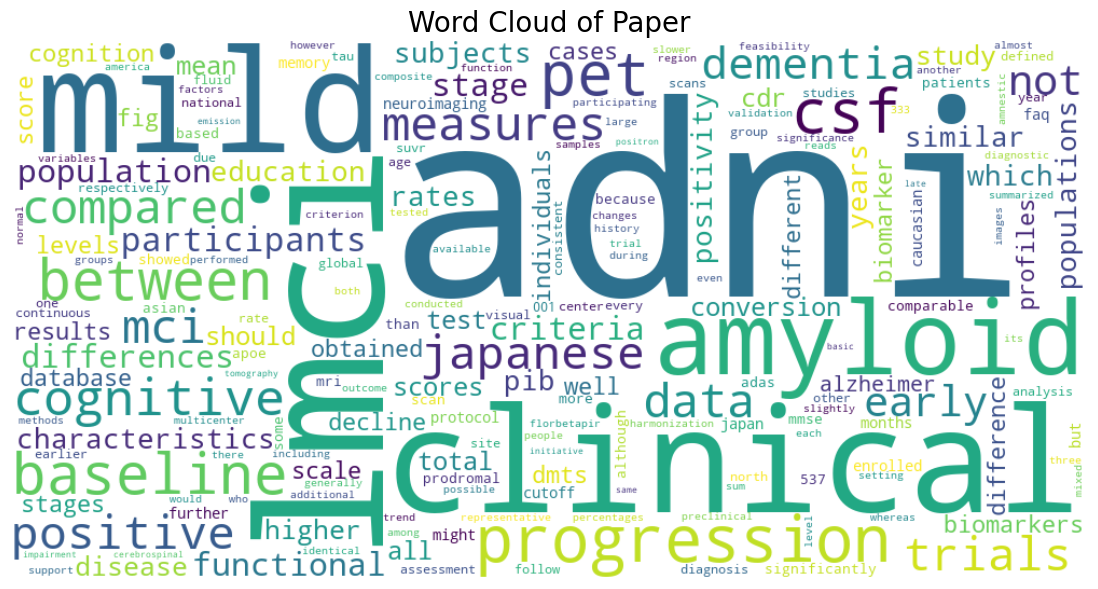

: 

In [ ]:



# ------------------------------------
# Load spaCy model for NER
# ------------------------------------
nlp = spacy.load("en_core_web_sm")

# ------------------------------------
# Load the cleaned train.csv file
# ------------------------------------
train_csv_path = "datasets/cleaned_train.csv"
df = pd.read_csv(train_csv_path)

# ------------------------------------
# Define the paper ID
# ------------------------------------
paper_id = "60246e83-563c-41be-afb7-19d536fc66fc"

# ------------------------------------
# Display datasets mentioned in the paper
# ------------------------------------
def show_datasets_in_paper(paper_id, df):
    paper_row = df[df["Id"] == paper_id]
    print("\nDatasets mentioned in the paper:")
    print(paper_row[["dataset_title", "dataset_label"]].drop_duplicates())

show_datasets_in_paper(paper_id, df)

# ------------------------------------
# Load paper JSON safely
# ------------------------------------
def load_paper_json(paper_id, json_path="datasets"):
    paper_file = os.path.join(json_path, f"{paper_id}.json")
    with open(paper_file, "r", encoding="utf-8") as f:
        paper = json.load(f)
    return paper

# ------------------------------------
# Display first few paragraphs
# ------------------------------------
def display_paper_intro(paper_id, json_path="datasets", num_paragraphs=5):
    paper = load_paper_json(paper_id, json_path)
    print(f"\n--- First {num_paragraphs} Paragraphs from Paper ID: {paper_id} ---")
    for p in paper[:num_paragraphs]:
        print(p["text"][:500])  # Limit paragraph length
        print("=" * 50)

display_paper_intro(paper_id, json_path="datasets")

# ------------------------------------
# Step 1: Word Frequency Analysis (without stopwords)
# ------------------------------------
def word_frequency_analysis(paper_id, json_path="datasets"):
    paper = load_paper_json(paper_id, json_path)
    text = " ".join([p["text"] for p in paper])
    
    stopwords = set([
        "the", "and", "in", "to", "of", "for", "with", "on", "by", "a", "an",
        "as", "at", "is", "was", "were", "it", "that", "this", "be", "been",
        "being", "has", "have", "had", "we", "will", "or", "from", "are", "such",
        "also", "may", "can", "using", "use", "used", "our", "these", "those"
    ])
    
    words = re.findall(r'\b\w+\b', text.lower())
    filtered_words = [word for word in words if word not in stopwords and len(word) > 2]
    word_counts = Counter(filtered_words)
    
    print("\nMost common words (without stopwords):")
    for word, count in word_counts.most_common(10):
        print(f"{word}: {count}")
    
    return word_counts

# ------------------------------------
# Step 2: Named Entity Recognition (NER)
# ------------------------------------
def named_entity_recognition(paper_id, json_path="datasets"):
    paper = load_paper_json(paper_id, json_path)
    text = " ".join([p["text"] for p in paper])
    doc = nlp(text)
    
    entities = [ent.text.strip() for ent in doc.ents if len(ent.text.strip()) > 2]
    entity_counts = Counter(entities)
    
    print("\nMost common named entities:")
    for entity, count in entity_counts.most_common(10):
        print(f"{entity}: {count}")
    
    return entity_counts

# ------------------------------------
# Step 3: Generate Word Cloud
# ------------------------------------
def generate_word_cloud(word_counts):
    wordcloud = WordCloud(width=1000, height=500, background_color="white").generate_from_frequencies(word_counts)
    
    plt.figure(figsize=(15, 7))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title("Word Cloud of Paper", fontsize=20)
    plt.show()

# ------------------------------------
# Step 4: Plot Word Frequency (Plotly)
# ------------------------------------
def plot_word_frequency(word_counts):
    top_words = dict(word_counts.most_common(10))
    data = pd.DataFrame({"Word": list(top_words.keys()), "Count": list(top_words.values())})
    
    fig = px.bar(
        data,
        x="Word",
        y="Count",
        title="Top 10 Most Common Words (Without Stopwords)",
        labels={"Word": "Word", "Count": "Frequency"},
        color="Count",
        color_continuous_scale="Viridis"
    )
    fig.show()

# ------------------------------------
# ===================
# RUNNING THE ANALYSIS
# ===================
# ------------------------------------
print("\nWord Frequency Analysis (without stopwords):")
word_counts = word_frequency_analysis(paper_id, json_path="datasets")

print("\nNamed Entity Recognition (NER):")
entity_counts = named_entity_recognition(paper_id, json_path="datasets")

# Word Cloud
generate_word_cloud(word_counts)

# Plotly interactive bar chart
plot_word_frequency(word_counts)







In [50]:
def plot_named_entities(entity_counts, top_n=10):
    # Prepare the data for Plotly bar chart
    entities = [entity for entity, _ in entity_counts.most_common(top_n)]
    counts = [count for _, count in entity_counts.most_common(top_n)]
    
    # Create a DataFrame for better handling with Plotly
    data = pd.DataFrame({"Entity": entities, "Count": counts})
    
    # Create a bar chart using Plotly
    fig = px.bar(data, x="Entity", y="Count", title="Top 10 Named Entities",
                 labels={"Entity": "Entity", "Count": "Frequency"}, color="Count", color_continuous_scale="Viridis")
    
    # Show the plot
    fig.show()

# Run the NER function
entity_counts = named_entity_recognition(paper_id, json_path="datasets")

# Plot the named entities
plot_named_entities(entity_counts)



Most common named entities:
ADNI: 49
LMCI: 31
AD: 15
MCI: 15
Japanese: 14
CSF: 14
PET: 13
Fig: 7
Japan: 6
FAQ: 6
